In [13]:
#from datetime import datetime, timedelta
from iexfinance.stocks import get_historical_data
from iexfinance.refdata import get_symbols
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import hvplot.pandas
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [12]:
token = os.getenv("IEX_TOKEN")
tickers = pd.DataFrame(get_symbols())
random = tickers.sample(1000)
symbols = random.symbol.to_frame()
symbols.to_csv("Data/symbols1000.csv", index=False)

In [ ]:
index_funds = pd.read_csv("Data/index_funds.csv", index_col="PX_LAST", parse_dates=True, infer_datetime_format=True)

In [ ]:
new_index_funds = index_funds.loc['2018-11-01':'2019-12-01']

In [ ]:
aapl = pd.read_csv("Data/aapl.csv", index_col="date", parse_dates=True, infer_datetime_format=True)
aapl = aapl['close'].to_frame()

In [78]:
sp500_fundamentals = pd.read_csv("Data/company_fundamentals.csv")
sp500_fundamentals.columns

Index(['Companies', 'Ticker', 'PE_Calc', 'PBV_Calc', 'IQ_MarketCap',
       'IQ_TOTAL_DEBT_CAPITAL', 'IQ_NI_NORM_MARGIN', 'Return on Equity_Calc',
       'IQ_RETURN_ASSETS', 'IQ_BETA_2YR'],
      dtype='object')

In [76]:
#import clustering data
sp500_fundamentals = pd.read_csv("Data/Fundamentals_Clustering_12-6-2019.csv")
#sp500_fundamentals = pd.read_csv("Data/company_fundamentals.csv")
sp500_fundamentals = sp500_fundamentals.dropna()
sp500_fundamentals['Ticker'] = sp500_fundamentals.Ticker.apply(lambda x: x[x.find(":")+1:])
sp500_fundamentals = sp500_fundamentals[sp500_fundamentals.IQ_PE_EXCL!='(Invalid Identifier)']

In [77]:
#keep nessessary columns
colnames_keep = sp500_fundamentals.columns[1:]
#colnames_keep =['Ticker', 'PE_Calc', 'Return on Equity_Calc', 'IQ_BETA_2YR']
sp500_fundamentals = sp500_fundamentals[colnames_keep]

In [78]:
#replace 0 and NM values with NA
sp500_fundamentals = sp500_fundamentals.replace("0", np.nan)
sp500_fundamentals = sp500_fundamentals.replace("NM", np.nan)
#sp500_fundamentals = sp500_fundamentals.replace("#DIV/0!", np.nan)


In [ ]:
#import industry data
sp500_industry = pd.read_csv("Data/industry.csv")
sp500_industry['Ticker'] = sp500_industry.Ticker.apply(lambda x: x[x.find(":")+1:])

In [ ]:
#merge industry data and fundamental data
sp500 = pd.merge(sp500_fundamentals, sp500_industry, on="Ticker")
sp500 = pd.get_dummies(sp500, columns=['Industry'])
sp500_fundamentals.shape

In [70]:
#fill NAs
def deal_with_na (df, method):
    if method == "ml":
        #drop first column
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        #drop rows with more than 2 NAs
        df = df.dropna(thresh=df.shape[1]-1)
        tickers = df.iloc[:,0].to_frame()
        data_without_null = df.dropna() 
        for i in range(0, df.shape[1]):
            print(df.columns[i])
            colname = df.columns[i]
            X_train = data_without_null.drop(columns=[colname])
            y_train = data_without_null[colname]
            X_test = df[df[colname].isnull()].drop(columns=[colname])
            if X_test.shape[0] != 0:
                linreg = LinearRegression()
                linreg.fit(X_train, y_train)
                predicted = linreg.predict(X_test)
                df[colname][df[colname].isnull()] = predicted
        output = pd.concat([tickers, df], axis=1)
        return output
    if method == "ts":
        #drop first column
        first_colname = df.columns[0]
        df = df.drop(columns=first_colname)
        df = df.astype('float')
        tickers = df.iloc[:,0].to_frame()
        for i in range(0, df.shape[1]):
            colname = df.columns[i]
            colmean = df[colname].median()
            df[colname]=df[colname].fillna(colmean)
        output = pd.concat([tickers, df], axis=1)
        return output
        

In [80]:
#sp500_no_na = deal_with_na(sp500_fundamentals, 'ml')
sp500_no_na = deal_with_na(sp500_fundamentals, 'ts')
#sp500_no_na = sp500_fundamentals.dropna()


In [81]:
sp500_kmeans = sp500_no_na.iloc[:,1:]
#sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(sp500_kmeans)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [82]:
model = KMeans(n_clusters=4)
model.fit(sp500_kmeans)
predictions = model.predict(sp500_kmeans)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'predictions'}, inplace=True)

In [83]:
sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
pca = PCA(n_components=6)
sp500_pca = pca.fit_transform(sp500_scaled)
pca.explained_variance_ratio_

array([0.19057097, 0.17163719, 0.14925247, 0.13156401, 0.094048  ,
       0.07695619])

In [ ]:
sp500_pca = pd.DataFrame(
    data=sp500_pca, columns=["pc1", "pc2", 'pc3']
)
sp500_pca.hvplot.scatter(x='pc1', y='pc2')

In [84]:
sp500_pca = pd.DataFrame(
    data=sp500_pca, columns=["pc1", "pc2", 'pc3', 'pc4', 'pc5', 'pc6']
)

sp500_pca_pred = pd.concat([sp500_pca, predictions], axis=1)
sp500_pca_pred.hvplot.scatter(x='pc1', y='pc2', by='predictions')

:NdOverlay   [predictions]
   :Scatter   [pc1]   (pc2)

In [61]:
# sp500_no_na.loc[sp500_pca_pred.pc1<5,:]
sp500_no_na = sp500_no_na.reset_index(drop=True)
sp500_no_na = sp500_no_na.loc[sp500_pca_pred.pc1<5,:]

In [62]:
sp500_kmeans = sp500_no_na.iloc[:,1:]
#sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
inertia = []
k = list(range(1, 11))
for i in k:
    km = KMeans(n_clusters=i)
    km.fit(sp500_kmeans)
    inertia.append(km.inertia_)

elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [63]:
model = KMeans(n_clusters=5)
model.fit(sp500_kmeans)
predictions = model.predict(sp500_kmeans)
predictions = pd.DataFrame(predictions)
predictions.rename(columns={0:'predictions'}, inplace=True)

In [64]:
sp500_scaled = StandardScaler().fit_transform(sp500_kmeans)
pca = PCA(n_components=6)
sp500_pca = pca.fit_transform(sp500_scaled)
pca.explained_variance_ratio_

array([0.2461939 , 0.21102844, 0.18047768, 0.15503655, 0.08400396,
       0.0419904 ])

In [65]:
sp500_pca = pd.DataFrame(
    data=sp500_pca, columns=["pc1", "pc2", 'pc3', 'pc4', 'pc5', 'pc6']
)

sp500_pca_pred = pd.concat([sp500_pca, predictions], axis=1)
sp500_pca_pred.hvplot.scatter(x='pc1', y='pc2', by='predictions')

:NdOverlay   [predictions]
   :Scatter   [pc1]   (pc2)

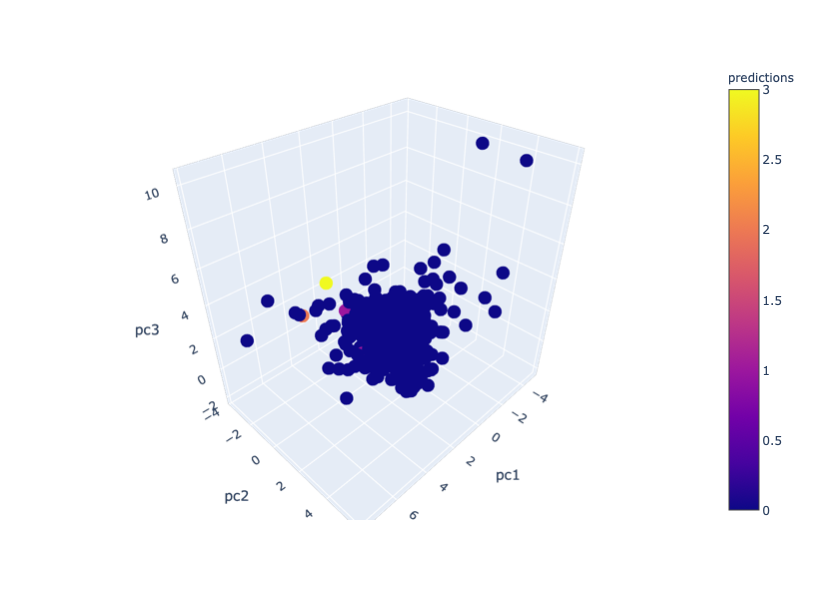

In [85]:
fig = px.scatter_3d(sp500_pca_pred, x='pc1', y='pc2', z='pc3', color='predictions')
fig.show()